## Hit calling - large pooled screen

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import re

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Functions

In [2]:
def get_hit_candidates(pvals, zscore_threshold=1.5, padj_threshold=0.05, n_cells_treated_threshold=20, n_cells_control_threshold=100, score_threshold=5,
                       compounds_discard=None, features_discard=None,
                       hit_candidates_savepath=None, scores_savepath=None, padjs_savepath=None, scores_save_all_settings=False,
                       hit_candidates_vpcells_savepath=None, screen_ID=None, vpcells_link_root=""):
    # Bonferroni correction
    pvals["padj"] = pvals["pval"] * pvals.shape[0]
    # zscore
    pvals["zscore_treated"] = (pvals["mean_treated"] - pvals["mean_control"])/pvals["std_control"]

    # filter the records for "interesting" = passing criteria
    pvals_interest = pvals.query(f'abs(zscore_treated) > {zscore_threshold} & padj < {padj_threshold} & n_cells_treated > {n_cells_treated_threshold} & n_cells_control > {n_cells_control_threshold}')
    pvals_interest = pvals_interest[(~pvals_interest.compound.isin(compounds_discard)) & (~pvals_interest.variable.isin(features_discard))]

    # score = number of interesting
    id_cols = ["protein", "sgRNA", "compound", "AssayConc_uM", "clone", "plate", "well", "frame", "n_cells_treated", "n_cells_control"]
    scores = pvals_interest[id_cols].value_counts().rename("score").sort_values(ascending=False).reset_index()
    scores = scores.sort_values(["score",  "sgRNA", "compound", "AssayConc_uM"], ascending = [False, True, True, True]).reset_index(drop=True).reset_index().rename(columns={"index":"rank"})
    scores["rank"]+=1
    
    # hit candidates = scores above threshold
    hit_candidates = scores.query(f"score >= {score_threshold}").sort_values("rank")
    
    if scores_save_all_settings:
        settings = pvals[id_cols].drop_duplicates().sort_values(["protein", "sgRNA", "compound", "AssayConc_uM"])
        scores = settings.merge(scores, on=id_cols, how='left').fillna({'score': 0})
        scores["score"] = scores["score"].astype("int")
    
    if hit_candidates_savepath: hit_candidates.to_csv(hit_candidates_savepath, index=None)
    if scores_savepath: scores.to_csv(scores_savepath, index=None)
    if padjs_savepath: pvals.to_csv(padjs_savepath, index=None)
    
    if hit_candidates_vpcells_savepath:
        vpcells_cols = ['protein', 'compound', 'sgRNA', 'clone', 'frame', 'well', 'plate']
        for hit_idx in hit_candidates.index.to_list():
            protein, compound, sgRNA, clone, frame, well, plate = hit_candidates.loc[hit_idx, vpcells_cols]
            hit_candidates.loc[hit_idx, "vpcells_link"] = vpcells_link_root + encode_visualization(protein, compound, screen_ID, sgRNA, clone, frame, well, plate)

        max_field_width = 20

        # Generate HTML table with nowrap style
        html = hit_candidates.to_html(classes='styled-table', render_links=True, index=None)

        # Add CSS styling
        html = f'<style>.styled-table {{ font-family: Source Sans Pro,system-ui, sans-serif; border-collapse: collapse; width: 100%; }}' \
               f'.styled-table td, .styled-table th {{ border: 1px solid #ddd; padding: 5px; font-size: 14px; ' \
               f'white-space: nowrap; text-overflow: ellipsis; overflow: hidden; max-width: {max_field_width}px; }}' \
               f'.styled-table tr:nth-child(even){{ background-color: #f2f2f2; }}' \
               f'.styled-table td:hover {{ overflow: ellipsis; white-space: nowrap; }}' \
               f'.styled-table th {{ padding-top: 7px; padding-bottom: 7px; text-align: left; ' \
               f'background-color: #0F2310; color: white; }}</style>\n' + html

        # Print or save the HTML
        with open(hit_candidates_vpcells_savepath, mode="w", encoding="utf-8") as f:
            f.write(html)

    return hit_candidates, scores, pvals, pvals_interest

### Config

In [38]:
version = "2023-07-11_final"

pvals_path = "/nobackup/lab_kubicek/jreinis/2023-06-14_pooled_arrayed_hit_candidates_v2/01_pvals/2023-06-21_pooled_pvals_all_plates_final_replicates_DMSO_controls_merged_allplates.pickle"

padjs_savepath = f"/nobackup/lab_kubicek/jreinis/2023-06-14_pooled_arrayed_hit_candidates_v2/01b_padjs/{version}_padjs_pooled.csv"
pvals_interest_savepath = f"/nobackup/lab_kubicek/jreinis/2023-06-14_pooled_arrayed_hit_candidates_v2/01b_padjs/{version}_pooled_pvals_interest_all_plates_final_replicates_DMSO_controls_merged_allplates.csv"
hit_candidates_savepath = f"/nobackup/lab_kubicek/jreinis/2023-06-14_pooled_arrayed_hit_candidates_v2/03_hit_candidates_ranked/{version}_hit_candidates_pooled.csv"
scores_savepath = f"/nobackup/lab_kubicek/jreinis/2023-06-14_pooled_arrayed_hit_candidates_v2/02_scores/{version}_scores_all.csv"

manual_annotation_path = "/nobackup/lab_kubicek/jreinis/2023-06-14_pooled_arrayed_hit_candidates_v2/04_hit_candidates_annotated/2023-07-11_final_hit_candidates_annotated.xlsx"

In [4]:
padj_threshold = 0.05
n_cells_treated_threshold = 50
n_cells_control_threshold = 100
zscore_threshold = 1.5

score_threshold = 5

In [5]:
autofluorescent_cpds = [
    "AG690/40696416",
    "Bosutinib",
    "Daunorubicin",
    "Dipyridamole",
    "MK2206",
    "Nabilone",
    "Obatoclax Mesylate",
    "Sunitinib",
    "Z1266933828",
    "Z1465002628",
    "Z169664878",
    "Z197467238",    
    "Z238657074",
    "Z276117100",
    "Z277970840",
    "Z4209355078",
    "Z48836843",
    "Z55164287",
    "Z56762970",
    "Z56779052",
    "Z56795285",
    "Z57947836",
    "Z1252133816",
    "Toceranib",
    "Pyrvinium Chloride Dihydrate",
    "Z277979698",
    "Aclarubicin",
    "Z89264907",
    "Semaxanib",
    "Z241896872",
]

# unstable features - discard
features_discard = ["Granularity_16_cytoplasm", "Granularity_16_nucleus", "Granularity_15_cytoplasm", "Granularity_15_nucleus"]

### Get the list of hit candidates

In [6]:
pvals = pd.read_pickle(pvals_path).rename(columns={"CompoundName":"compound"})

In [7]:
hit_candidates, scores, padjs, pvals_interest = get_hit_candidates(pvals, zscore_threshold, padj_threshold, n_cells_treated_threshold, n_cells_control_threshold, score_threshold, autofluorescent_cpds, features_discard,
                                                                   hit_candidates_savepath, scores_savepath, padjs_savepath, scores_save_all_settings=True)

In [8]:
hit_candidates

,rank,protein,sgRNA,compound,AssayConc_uM,clone,plate,well,frame,n_cells_treated,n_cells_control,score
0,1,RHEB,RHEB_ENST00000262187_Intron2_Frame1_sgRNA02,Mycophenolic Acid,10.0,E07,AR_20230414_HAP1_cancer_41clones_pooled_cpdpla...,B02,mScarlet,334,46323,22
1,2,DAZAP1,DAZAP1_Intron4_1,SNS-032,20.0,C07,AR_20230416_HAP1_cancer_41clones_pooled_cpdpla...,A11,GFP,177,37700,21
2,3,PPP2R1A,PPP2R1A_ENST00000322088_Intron11_Frame1_sgRNA01,UCN-01 (7-hydroxystaurosporine),10.0,A05,AR_20230416_HAP1_cancer_41clones_pooled_cpdpla...,E01,mScarlet,52,59579,21
3,4,RHEB,RHEB_ENST00000262187_Intron2_Frame1_sgRNA02,UCN-01 (7-hydroxystaurosporine),10.0,E07,AR_20230416_HAP1_cancer_41clones_pooled_cpdpla...,E01,mScarlet,115,46323,20
4,5,MAP2K1,MAP2K1_ENST00000307102_Intron7_Frame1_sgRNA02,UCN-01 (7-hydroxystaurosporine),10.0,B03,AR_20230416_HAP1_cancer_41clones_pooled_cpdpla...,E01,mScarlet,70,45229,18
...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,SF1,SF1_Intron9_2,Triptolide,10.0,A02,AR_20230408_HAP1_cancer_41clones_pooled_cpdpla...,D01,GFP,215,19544,5
95,96,SIN3A,SIN3A_ENST00000394947_Intron15_Frame1_sgRNA01,Mithramycin A,10.0,D07,AR_20230404_HAP1_cancer_41clones_pooled_cpdpla...,H07,mScarlet,437,39730,5
96,97,SMARCA4,SMARCA4_ENST00000344626_Intron33_Frame1_sgRNA01,ACBI1,0.1,E02,AR_20230528_HAP1_cancer_41clones_pooled_cpdpla...,C06,mScarlet,480,37579,5
97,98,TXNIP,TXNIP_Intron3_2,Mithramycin A,10.0,E03,AR_20230404_HAP1_cancer_41clones_pooled_cpdpla...,H07,GFP,186,43144,5


In [39]:
pvals_interest.to_csv(pvals_interest_savepath, index=None)

### Plots - hit candidate confirmation status (add manual annotation information)

In [11]:
annot = pd.read_excel(manual_annotation_path)
hit_candidates = hit_candidates.merge(annot, how="left")

In [12]:
ncol = 5
hit_candidates["row"] = ncol*((hit_candidates["rank"]-1)//ncol)
hit_candidates["column"] = (hit_candidates["rank"]-1)%ncol

In [13]:
palette3 = {
    "confirmed hit": "#006400",
    "general effect on cells or toxicity": "#00FF00",
    "clones losing expression": "mediumseagreen",
    "clone changing intensity (D04)": "darkcyan",
    "no apparent effect": "red",
}

In [14]:
orderys = ['confirmed hit', 'no apparent effect', 'general effect on cells or toxicity', 'clones losing expression', 'clone changing intensity (D04)']
hit_candidates.status_pool = pd.Categorical(hit_candidates.status_pool, categories=orderys, ordered=True)

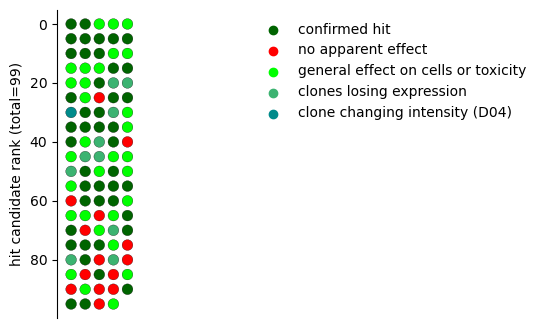

In [15]:
plt.figure(figsize=(2,4))
plt.gca().invert_yaxis()
ax = sns.scatterplot(data=hit_candidates, x = "column", y = "row", hue="status_pool", s=60, linewidth=0.2, edgecolor="black", palette=palette3)
plt.xlabel('')
plt.ylabel('hit candidate rank (total=99)')
plt.xticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xlim(-1., 10)

legend = plt.legend(bbox_to_anchor=(1.22, 1), loc='upper left')
legend.get_frame().set_visible(False)

plt.savefig("/nobackup/lab_kubicek/jreinis/2023-06-30_plots_images_paper/hit_candidates_status.pdf", bbox_inches="tight")
plt.show()

### Plots - sgRNAs vs compounds heatmap - only confirmed hits

In [16]:
savepath = "/nobackup/lab_kubicek/jreinis/2023-06-30_plots_images_paper/heatmap_sgRNAs_cpds.pdf"

In [17]:
id_cols = ["protein", "sgRNA", "compound", "AssayConc_uM", "clone", "plate", "well", "frame", "n_cells_treated", "n_cells_control"]

In [18]:
# only confirmed hits
pvals_confirmed = pvals_interest.merge(hit_candidates.query("status_pool == 'confirmed hit'")[id_cols], on=id_cols)
pvals_confirmed.plate = pvals_confirmed['plate'] = pd.factorize(pvals_confirmed['plate'])[0].astype("str")
pvals_confirmed.well = pvals_confirmed['well'] = pd.factorize(pvals_confirmed['well'])[0].astype("str")

In [19]:
to_reshape = pvals_confirmed[["sgRNA", "clone", "compound", "AssayConc_uM", "plate", "well"]].value_counts().rename("score").reset_index()

# differentiate different concentration of same compound, and different sgRNAs/clones for the same protein
to_reshape["compound_"] = to_reshape["compound"] + "_" + to_reshape["AssayConc_uM"].astype("str") + "_" + to_reshape["plate"] + "_" + to_reshape["well"]
to_reshape["sgRNA_"] = to_reshape["sgRNA"] + "_" + to_reshape["clone"]

# the same but labels
to_reshape["compound_label"] = to_reshape["compound"] + ", " + to_reshape["AssayConc_uM"].round(2).astype("str").str.replace(r'\.0$', '', regex=True) + "μM"
to_reshape["sgRNA_label"] = pd.Series([x.split("_")[0] for x in to_reshape["sgRNA"]]) + ", intron " + [re.search(r"_Intron(\d+)_", x).group(1) for x in to_reshape.sgRNA] + " (" + to_reshape["clone"] + ")"

to_reshape[["sgRNA_", "sgRNA_label", "compound_", "compound_label", "score"]]

,sgRNA_,sgRNA_label,compound_,compound_label,score
0,RHEB_ENST00000262187_Intron2_Frame1_sgRNA02_E07,"RHEB, intron 2 (E07)",Mycophenolic Acid_10.0_5_8,"Mycophenolic Acid, 10μM",22
1,DAZAP1_Intron4_1_C07,"DAZAP1, intron 4 (C07)",SNS-032_20.0_8_11,"SNS-032, 20μM",21
2,RHEB_ENST00000262187_Intron2_Frame1_sgRNA02_E07,"RHEB, intron 2 (E07)",Pralatrexate_20.0_4_7,"Pralatrexate, 20μM",18
3,SMARCA4_ENST00000344626_Intron24_Frame1_sgRNA0...,"SMARCA4, intron 24 (F04)",ACBI1_0.1_10_16,"ACBI1, 0.1μM",18
4,RHEB_ENST00000262187_Intron2_Frame1_sgRNA02_E07,"RHEB, intron 2 (E07)",Pralatrexate_7.0551_8_13,"Pralatrexate, 7.06μM",17
5,SMAD4_ENST00000398417_Intron4_Frame1_sgRNA01_E01,"SMAD4, intron 4 (E01)",Romidepsin_10.0_3_5,"Romidepsin, 10μM",17
6,SMAD4_ENST00000398417_Intron4_Frame1_sgRNA01_E01,"SMAD4, intron 4 (E01)",MG-132_10.0_12_20,"MG-132, 10μM",17
7,NPM1_Intron10_1_B03,"NPM1, intron 10 (B03)",SNS-032_20.0_8_11,"SNS-032, 20μM",16
8,SMARCA4_Intron1_1_C03,"SMARCA4, intron 1 (C03)",ACBI1_0.1_10_16,"ACBI1, 0.1μM",16
9,NPM1_Intron10_1_B03,"NPM1, intron 10 (B03)",Mithramycin A_10.0_0_0,"Mithramycin A, 10μM",16


In [20]:
order_compounds = list(to_reshape.groupby("compound_label")["score"].sum().sort_values(ascending=False).index)
order_sgRNAs = list(to_reshape.groupby("sgRNA_label")["score"].sum().sort_values(ascending=False).index)

reshaped = to_reshape.pivot(index="sgRNA_label", columns="compound_label", values="score").fillna(0).astype("int")
reshaped_ = reshaped.loc[order_sgRNAs, order_compounds]

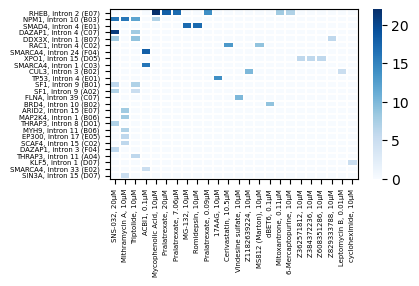

In [21]:
plt.figure(figsize=(4,2.2))
#ax = sns.heatmap(reshaped_, cmap="crest", mask=reshaped_==0)
ax = sns.heatmap(reshaped_, cmap="Blues", linewidth=0.01, xticklabels=True)
ax.tick_params(axis='x', labelsize=5)  # Adjust x-axis tick label size
ax.tick_params(axis='y', labelsize=5)

ytick_positions = np.arange(0.5, len(reshaped_.index)+.5, 1)  # Set the tick positions as the row indices
ytick_labels = reshaped_.index  # Set the tick labels as the row labels

xtick_positions = np.arange(0.5, len(reshaped_.columns)+.5, 1)  # Set the tick positions as the row indices

# Set the y-axis ticks
ax.set_yticks(ytick_positions)
ax.set_xticks(xtick_positions)
ax.set_yticklabels(ytick_labels)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha="center", va="center")
for _, spine in ax.spines.items():
    spine.set_visible(True)

cbar = ax.collections[0].colorbar

# Adjust the tick values of the colorbar
maxa = max(np.unique(reshaped_))
cbar.set_ticks(list(range(0, maxa, 5)))

plt.xlabel("")
plt.ylabel("")
plt.savefig(savepath, bbox_inches="tight")
plt.show()

### Plots - features vs compounds heatmap - only confirmed hits

In [22]:
savepath = "/nobackup/lab_kubicek/jreinis/2023-06-30_plots_images_paper/heatmap_features_cpds.pdf"

In [23]:
to_reshape = pvals_confirmed[["variable", "compound", "AssayConc_uM"]].value_counts().rename("score").reset_index()

# differentiate different concentration of same compound, and different sgRNAs/clones for the same protein
to_reshape["compound_"] = to_reshape["compound"] + "_" + to_reshape["AssayConc_uM"].astype("str")# + "_" + to_reshape["plate"] + "_" + to_reshape["well"]

# the same but labels
to_reshape["compound_label"] = to_reshape["compound"] + ", " + to_reshape["AssayConc_uM"].round(2).astype("str").str.replace(r'\.0$', '', regex=True) + "μM"

In [24]:
order_compounds = list(to_reshape.groupby("compound_label")["score"].sum().sort_values(ascending=False).index)
order_variables = list(to_reshape.groupby("variable")["score"].sum().sort_values(ascending=False).index)

reshaped = to_reshape.pivot(index="variable", columns="compound_label", values="score").fillna(0).astype("int")
reshaped_ = reshaped.loc[order_variables, order_compounds]

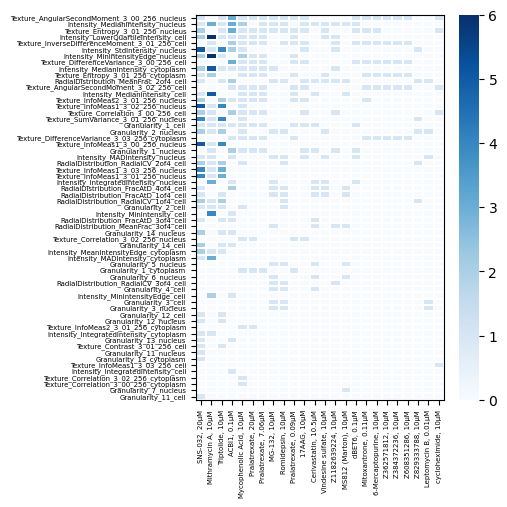

In [25]:
plt.figure(figsize=(4,5))
#ax = sns.heatmap(reshaped_, cmap="crest", mask=reshaped_==0)
ax = sns.heatmap(reshaped_, cmap="Blues", linewidth=0.01, xticklabels=True)
ax.tick_params(axis='x', labelsize=5)  # Adjust x-axis tick label size
ax.tick_params(axis='y', labelsize=5)

ytick_positions = np.arange(0.5, len(reshaped_.index)+.5, 1)  # Set the tick positions as the row indices
ytick_labels = reshaped_.index  # Set the tick labels as the row labels

xtick_positions = np.arange(0.5, len(reshaped_.columns)+.5, 1)  # Set the tick positions as the row indices

# Set the y-axis ticks
ax.set_yticks(ytick_positions)
ax.set_xticks(xtick_positions)
ax.set_yticklabels(ytick_labels)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha="center", va="center")
for _, spine in ax.spines.items():
    spine.set_visible(True)

cbar = ax.collections[0].colorbar

# Adjust the tick values of the colorbar
maxa = max(np.unique(reshaped_))
cbar.set_ticks(list(range(0, maxa+1, 1)))

plt.xlabel("")
plt.ylabel("")
plt.savefig(savepath, bbox_inches="tight")
plt.show()

### Plots - sgRNAs vs features heatmap - only confirmed hits

In [26]:
savepath = "/nobackup/lab_kubicek/jreinis/2023-06-30_plots_images_paper/heatmap_sgRNAs_features.pdf"

In [27]:
to_reshape = pvals_confirmed[["sgRNA", "clone", "variable"]].value_counts().rename("score").reset_index()

# differentiate different concentration of same compound, and different sgRNAs/clones for the same protein
to_reshape["sgRNA_label"] = pd.Series([x.split("_")[0] for x in to_reshape["sgRNA"]]) + ", intron " + [re.search(r"_Intron(\d+)_", x).group(1) for x in to_reshape.sgRNA] + " (" + to_reshape["clone"] + ")"

order_sgRNAs = list(to_reshape.groupby("sgRNA_label")["score"].sum().sort_values(ascending=False).index)
order_variables = list(to_reshape.groupby("variable")["score"].sum().sort_values(ascending=False).index)

reshaped = to_reshape.pivot(index="sgRNA_label", columns="variable", values="score").fillna(0).astype("int")
reshaped_ = reshaped.loc[order_sgRNAs, order_variables]

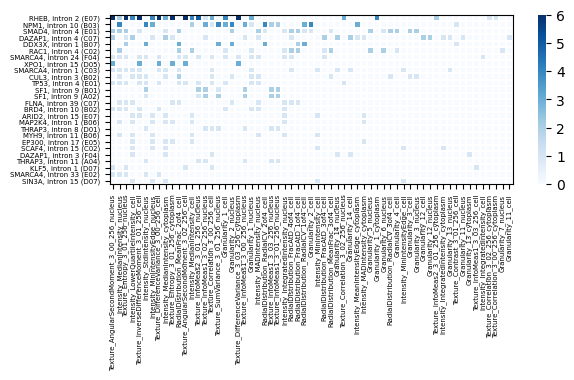

In [28]:
plt.figure(figsize=(6.5,2.2))
#ax = sns.heatmap(reshaped_, cmap="crest", mask=reshaped_==0)
ax = sns.heatmap(reshaped_, cmap="Blues", linewidth=0.01, xticklabels=True)
ax.tick_params(axis='x', labelsize=5)  # Adjust x-axis tick label size
ax.tick_params(axis='y', labelsize=5)

ytick_positions = np.arange(0.5, len(reshaped_.index)+.5, 1)  # Set the tick positions as the row indices
ytick_labels = reshaped_.index  # Set the tick labels as the row labels
xtick_positions = np.arange(0.5, len(reshaped_.columns)+.5, 1)  # Set the tick positions as the row indices

# Set the y-axis ticks
ax.set_yticks(ytick_positions)
ax.set_xticks(xtick_positions)
ax.set_yticklabels(ytick_labels)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha="center", va="center")
for _, spine in ax.spines.items():
    spine.set_visible(True)

cbar = ax.collections[0].colorbar

# Adjust the tick values of the colorbar
maxa = max(np.unique(reshaped_))
cbar.set_ticks(list(range(0, maxa+1, 1)))

plt.xlabel("")
plt.ylabel("")
plt.savefig(savepath, bbox_inches="tight")
plt.show()

### Plots - BRD4, dBET6

#### Median intensity nucleus for BRD4 for all compounds

In [29]:
savepath = "/nobackup/lab_kubicek/jreinis/2023-06-30_plots_images_paper/BRD4_dBET6_cpd_centric.pdf"

In [30]:
BRD4 = padjs.query(f'protein=="BRD4" & variable == "Intensity_MedianIntensity_nucleus"').copy()
BRD4 = BRD4[~BRD4.compound.isin(autofluorescent_cpds)]
BRD4["compound"] = BRD4.compound.str.replace("DMSO", "((00000_DMSO")
BRD4["compound"] = [x.lower() for x in BRD4["compound"]]
BRD4.sort_values("compound", inplace=True)

BRD4["compound_label"] = "screening compound"
BRD4.loc[BRD4.compound == "((00000_dmso", "compound_label"] = "DMSO"
BRD4.loc[BRD4.compound == "dbet6", "compound_label"] = "dBET6"
BRD4["log2FC"] = np.log2(BRD4["fold_change"])
BRD4 = BRD4.reset_index(drop=True).reset_index()

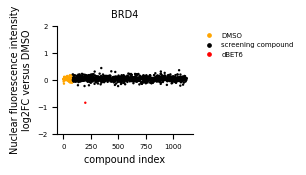

In [31]:
plt.figure(figsize=(1.75,1.4))
ax = sns.scatterplot(data=BRD4, y="log2FC", x="index", linewidth=0, hue="compound_label", s=3, palette={"screening compound":"black", "dBET6":"red", "DMSO":"orange"})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis='x', labelsize=5)  # Adjust x-axis tick label size
ax.tick_params(axis='y', labelsize=5)
plt.xlabel("compound index", fontsize=7)
plt.ylabel('Nuclear fluorescence intensity\n'+r'log2FC versus DMSO', fontsize=7)
#plt.ylabel("Nuclear fluorescence intensity\nlog_2(FC)", fontsize=7)
plt.ylim(-2,2)
plt.title("BRD4", fontsize=7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=5, frameon=False, markerscale=0.4)
plt.savefig(savepath, bbox_inches="tight")
plt.show()

#### dBET6 scores (more lenient settings)

In [32]:
savepath = "/nobackup/lab_kubicek/jreinis/2023-06-30_plots_images_paper/BRD4_dBET6_protein_centric.pdf"

In [33]:
padj_threshold = 0.05
n_cells_treated_threshold = 50
n_cells_control_threshold = 100
zscore_threshold = 0.5

score_threshold = 5

In [34]:
_, scores_lenient, __, ___ = get_hit_candidates(pvals, zscore_threshold, padj_threshold, n_cells_treated_threshold, n_cells_control_threshold, score_threshold, autofluorescent_cpds, features_discard, scores_save_all_settings=True)

In [35]:
scores_dBET6 = scores_lenient.query('compound == "dBET6"').sort_values(["sgRNA", "clone"]).reset_index(drop=True).reset_index()
scores_dBET6["is_BRD4"] = "nay"
scores_dBET6.loc[scores_dBET6.protein == "BRD4", "is_BRD4"] = "yey"

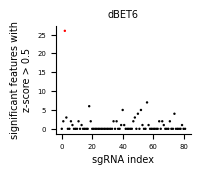

In [36]:
plt.figure(figsize=(1.75,1.4))
ax = sns.scatterplot(data=scores_dBET6, y="score", x="index", linewidth=0, hue="is_BRD4", s=3, legend=None, palette={"nay":"black", "yey":"red"})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis='x', labelsize=5)  # Adjust x-axis tick label size
ax.tick_params(axis='y', labelsize=5)
plt.xlabel("sgRNA index", fontsize=7)
plt.ylabel("significant features with\nz-score > 0.5", fontsize=7)
plt.title("dBET6", fontsize=7)
plt.savefig(savepath, bbox_inches="tight")
plt.show()